# Bicycle Dataset

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd
import contextily as ctx
from geopy.distance import geodesic

from shapely import wkt
from shapely.geometry import Point
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import tqdm
tqdm.pandas()

In [30]:
# Load the dataset

def filter_rows(index):
    # Load every 10th row
    return index % 10 != 0

columns = ["starttime", "stoptime", "start_lat", "start_lng", "end_lat", "end_lng"]

bike_dataset = pd.read_csv('data/bicycle_dataset.csv', 
                           usecols=columns, 
                           skiprows=lambda x: filter_rows(x))

In [31]:
bike_dataset.sample(3)

,starttime,stoptime,start_lat,start_lng,end_lat,end_lng
8321945,2022-11-20 12:30:52,2022-11-20 12:43:28,40.722992,-73.979955,40.718939,-73.992663
1416086,2019-08-06 18:25:09.5210,2019-08-06 18:28:34.1020,40.730563,-73.973984,40.725213,-73.977688
276485,2019-10-20 01:33:41.2270,2019-10-20 01:44:41.2370,40.731724,-74.006744,40.727791,-73.985649


In [32]:
print("The shape of the data is: ", bike_dataset.shape)

The shape of the data is:  (9840992, 6)


### Data Pre-Processing
This section will cover the following:
- Convert starttime and stoptime to datetime
- Check for NaN and Duplicate values
- Append zone based on coordinates

In [33]:
# Convert starttime and stoptime to datetime
bike_dataset["starttime"] = pd.to_datetime(bike_dataset["starttime"], format='mixed')
bike_dataset["stoptime"] = pd.to_datetime(bike_dataset["stoptime"], format='mixed')

In [34]:
# Check for NaN values
display(bike_dataset.isnull().sum())
print("Duplicates: ", bike_dataset.duplicated().sum())

starttime       0
stoptime        0
start_lat       0
start_lng       0
end_lat      9772
end_lng      9772
dtype: int64

Duplicates:  24


In [7]:
# Drop rows with NaN values and duplicates
bike_dataset.dropna(inplace=True)
bike_dataset.drop_duplicates(inplace=True)
print("The shape of the data is: ", bike_dataset.shape)

The shape of the data is:  (9831196, 6)


#### Append Zone based on Coordinates

In [4]:
# Load the zones
zones = pd.read_csv('./data/taxi_zones.csv')
zones['the_geom'] = zones['the_geom'].apply(wkt.loads)
zones = gpd.GeoDataFrame(zones, geometry='the_geom')
zones['centroid'] = zones['the_geom'].centroid

zones_lookup = pd.read_csv('./data/taxi_zone_lookup.csv')

In [ ]:
# Define geometry
geometry = [Point(lon, lat) for lon, lat in zip(bike_dataset['start_lng'], bike_dataset['start_lat'])]
crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate system
points_gdf = gpd.GeoDataFrame(bike_dataset, crs=crs, geometry=geometry)

In [9]:
# Create a spatial index for the regions GeoDataFrame
zones_sindex = zones.sindex

# Create new columns to store start and end zones
points_gdf['start_zone'] = None
points_gdf['end_zone'] = None

# Iterate through each row in points_gdf
for index, point in tqdm(points_gdf.iterrows(), total=points_gdf.shape[0]):
    # Find the start zone
    possible_start_matches_index = list(zones_sindex.intersection(point.geometry.bounds))
    for start_region_index in possible_start_matches_index:
        if point.geometry.within(zones.loc[start_region_index, 'the_geom']):
            points_gdf.at[index, 'start_zone'] = zones.loc[start_region_index, 'zone']
            points_gdf.at[index, 'start_borough'] = zones.loc[start_region_index, 'borough']
            break
    
    # Find the end zone
    end_point = Point(point['end_lng'], point['end_lat'])
    possible_end_matches_index = list(zones_sindex.intersection(end_point.bounds))
    for end_region_index in possible_end_matches_index:
        if end_point.within(zones.loc[end_region_index, 'the_geom']):
            points_gdf.at[index, 'end_zone'] = zones.loc[end_region_index, 'zone']
            points_gdf.at[index, 'end_borough'] = zones.loc[end_region_index, 'borough']
            break
            
# Save the DataFrame
points_gdf.to_csv('./cleaned_data/bike_dataset_zones.csv', index=False)

100%|██████████| 9831196/9831196 [1:17:42<00:00, 2108.64it/s]


Calculate distance for each ride

In [ ]:
# Add distance column to the dataset
def calculate_distance(row):
    start = (row['start_lat'], row['start_lng'])
    end = (row['end_lat'], row['end_lng'])
    return geodesic(start, end).meters

bike_dataset['distance'] = bike_dataset.progress_apply(calculate_distance, axis=1)

In [ ]:
# Save the clean DataFrame
bike_dataset.to_pickle('./cleaned_data/bike_dataset_zones.pkl')

### Exploratory Data Analysis

In [5]:
# Load the cleaned dataset
bike_dataset = pd.read_pickle('./cleaned_data/bike_dataset_zones.pkl')
bike_dataset.dropna(inplace=True)

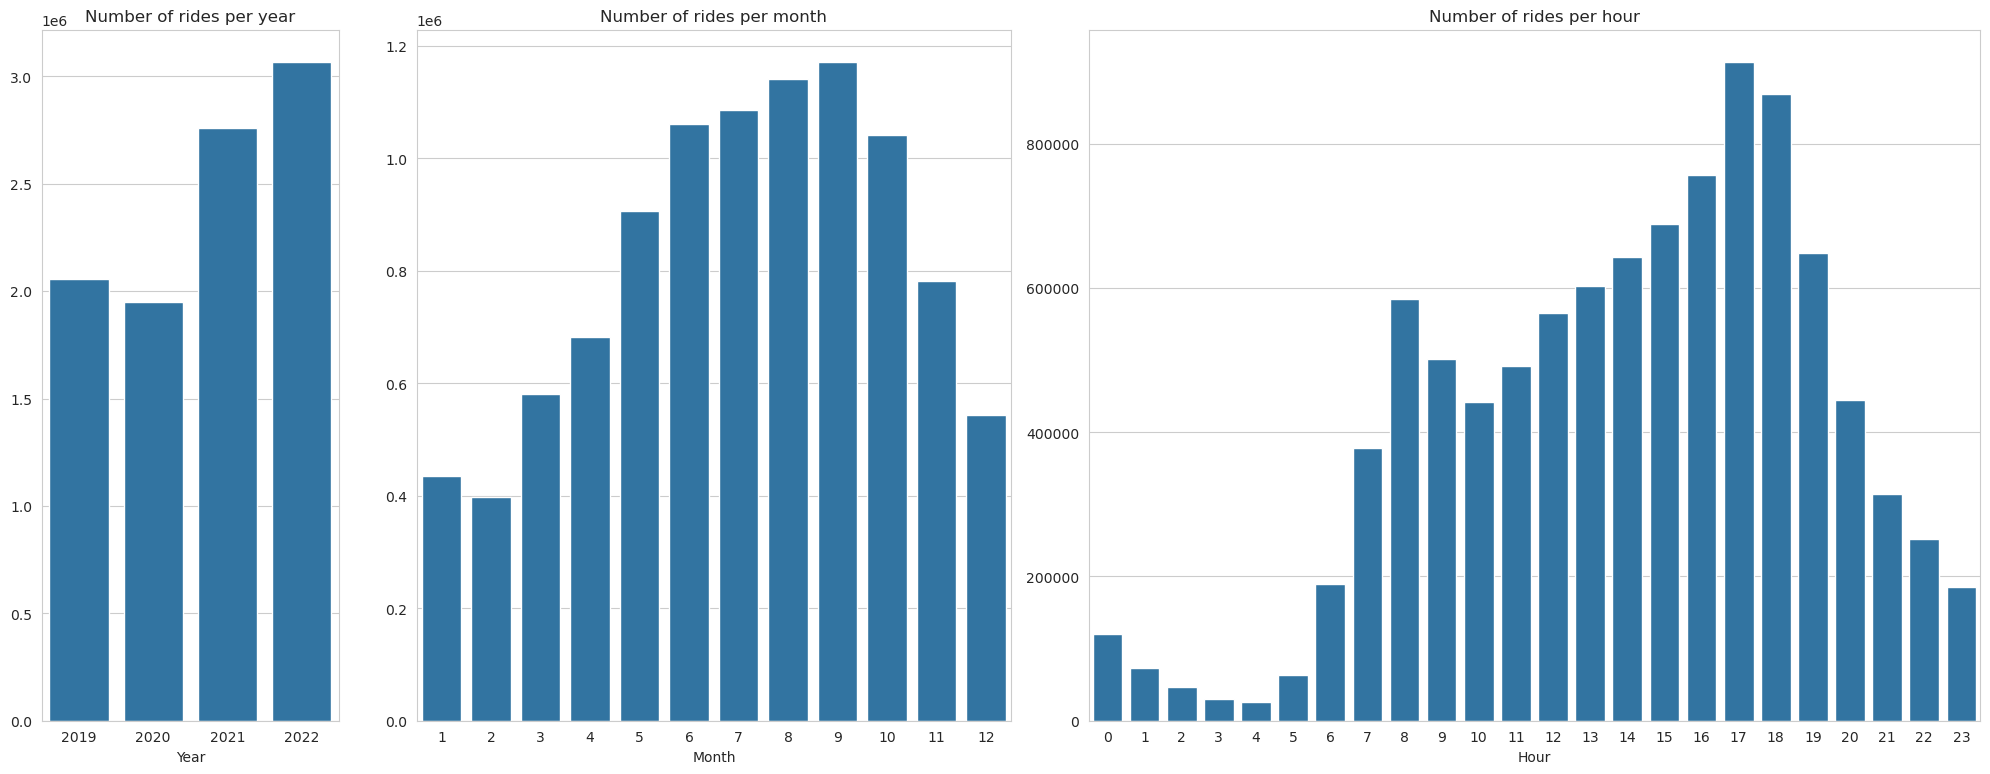

In [14]:
# Number of rides per year, per month, per hour
fig, ax = plt.subplots(1, 3, figsize=(20, 8), width_ratios=(1, 2, 3))

year_counts = bike_dataset["starttime"].dt.year.value_counts()
sns.barplot(x=year_counts.index, 
            y=year_counts.values, 
            ax=ax[0])
ax[0].set_title("Number of rides per year")
ax[0].set_xlabel("Year")

month_counts = bike_dataset["starttime"].dt.month.value_counts()
sns.barplot(x=month_counts.index, 
            y=month_counts.values, 
            ax=ax[1])
ax[1].set_title("Number of rides per month")
ax[1].set_xlabel("Month")

hour_counts = bike_dataset["starttime"].dt.hour.value_counts()
sns.barplot(x=hour_counts.index, 
            y=hour_counts.values, 
            ax=ax[2])
ax[2].set_title("Number of rides per hour")
ax[2].set_xlabel("Hour")

plt.tight_layout()

# Save plot
plt.savefig('./plots/rides_per_year_month_hour.png')

plt.show()

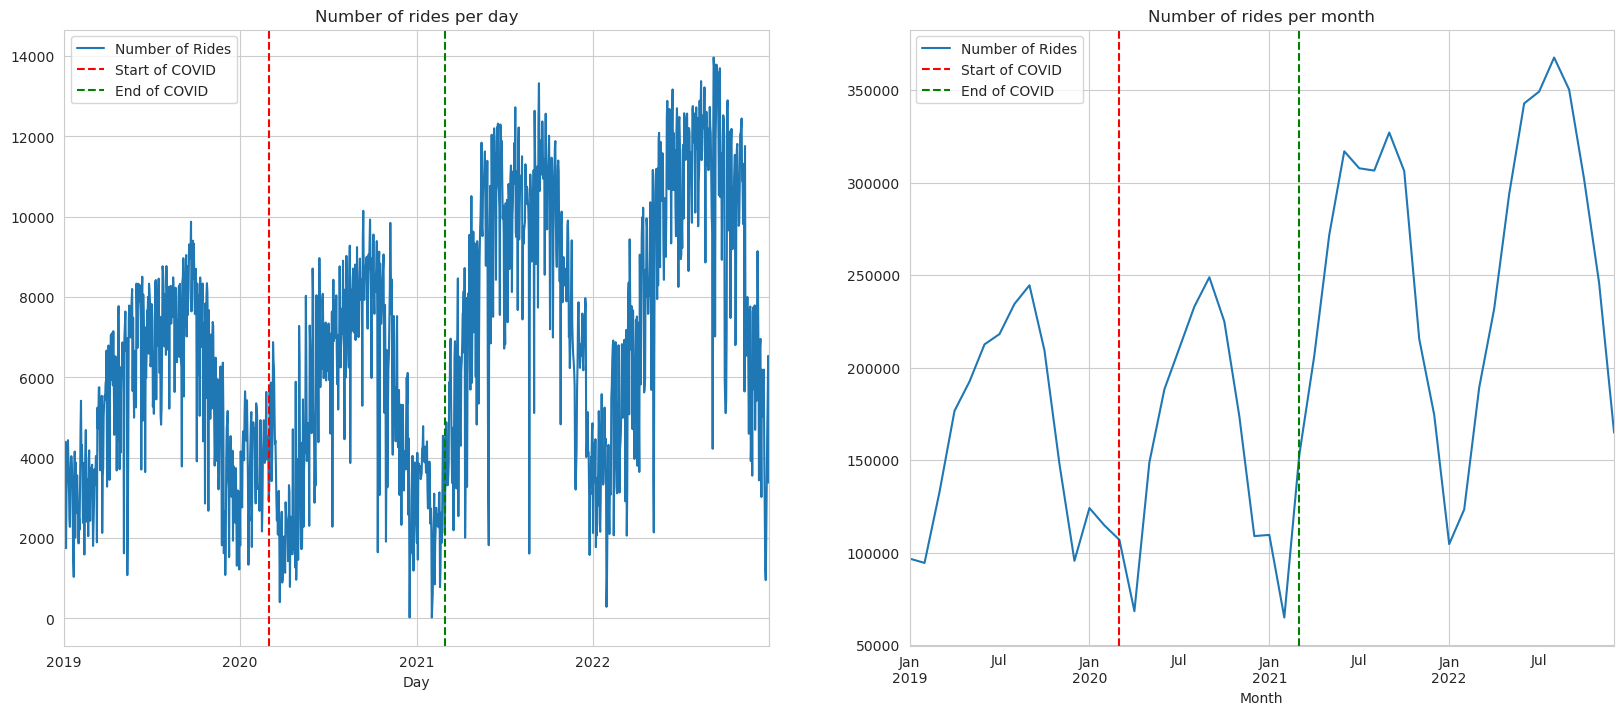

In [15]:
# Time series plot of the number of rides per month and per day
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

daily_counts = bike_dataset["starttime"].dt.to_period('D').value_counts().sort_index()
daily_counts.plot(ax=ax[0])
ax[0].set_title("Number of rides per day")
ax[0].set_xlabel("Day")

monthly_counts = bike_dataset["starttime"].dt.to_period('M').value_counts().sort_index()
monthly_counts.plot(ax=ax[1])
ax[1].set_title("Number of rides per month")
ax[1].set_xlabel("Month")

# Vertical line for COVID
ax[0].axvline(x=pd.Timestamp("2020-03-01"), color='r', linestyle='--')
ax[0].axvline(x=pd.Timestamp("2021-03-01"), color='g', linestyle='--')
ax[1].axvline(x=pd.Timestamp("2020-03-01"), color='r', linestyle='--')
ax[1].axvline(x=pd.Timestamp("2021-03-01"), color='g', linestyle='--')

# Legend
ax[0].legend(["Number of Rides", "Start of COVID", "End of COVID"])
ax[1].legend(["Number of Rides", "Start of COVID", "End of COVID"])

# Save plot
plt.savefig('./plots/rides_per_day_month.png')

plt.show()

### COVID Impact

Number of rides before COVID:  2293895
Number of rides during COVID:  1886310
Number of rides after COVID:  7536602


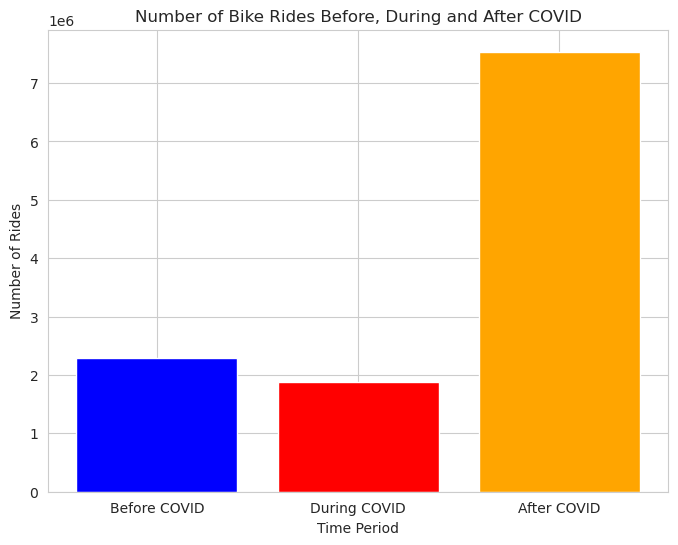

In [16]:
# Number of rides before March 2020
before_covid = bike_dataset[bike_dataset["starttime"] < "2020-03-01"]

# Number of rides after March 2020 and before March 2021
during_covid = bike_dataset[(bike_dataset["starttime"] >= "2020-03-01") & (bike_dataset["starttime"] < "2021-03-01")]

# Number of rides after March 2021
after_covid = bike_dataset[bike_dataset["starttime"] >= "2020-03-01"]

ride_counts = [before_covid.shape[0], during_covid.shape[0], after_covid.shape[0]]

print("Number of rides before COVID: ", ride_counts[0])
print("Number of rides during COVID: ", ride_counts[1])
print("Number of rides after COVID: ", ride_counts[2])

# Plot
labels = ['Before COVID', 'During COVID', 'After COVID']

plt.figure(figsize=(8, 6))
plt.bar(labels, ride_counts, color=['blue', 'red' , 'orange'])
plt.title('Number of Bike Rides Before, During and After COVID')
plt.ylabel('Number of Rides')
plt.xlabel('Time Period')

# Save plot
plt.savefig('./plots/rides_before_during_after_covid.png')

plt.show()

### Visualizing on a GeoMap
Heatmap representing starting locations before and after COVID

In [ ]:
# Heatmap before covid
latitudes = before_covid["start_lat"].values
longitudes = before_covid["start_lng"].values

# Create a folium map centered at the mean latitude and longitude with tiles
center_latitude = np.mean(latitudes)
center_longitude = np.mean(longitudes)
mymap = folium.Map(location=[center_latitude, center_longitude], zoom_start=11, tiles='Esri.WorldImagery')

# Combine latitudes and longitudes into a list of point coordinates
points = list(zip(latitudes, longitudes))

# Create a HeatMap layer with the points and add it to the map
HeatMap(points).add_to(mymap)

# Save the map to an HTML file
mymap.save("start_locations_before_covid.html", close_file=True)

In [15]:
# Heatmap during covid
latitudes = during_covid["start_lat"].values
longitudes = during_covid["start_lng"].values

# Create a folium map centered at the mean latitude and longitude with tiles
center_latitude = np.mean(latitudes)
center_longitude = np.mean(longitudes)
mymap = folium.Map(location=[center_latitude, center_longitude], zoom_start=11, tiles='Esri.WorldImagery')

# Combine latitudes and longitudes into a list of point coordinates
points = list(zip(latitudes, longitudes))

# Create a HeatMap layer with the points and add it to the map
HeatMap(points).add_to(mymap)

# Save the map to an HTML file
mymap.save("./maps/start_locations_during_covid.html", close_file=True)

In [ ]:
# Heatmap after covid
latitudes = after_covid["start_lat"].values
longitudes = after_covid["start_lng"].values

# Create a folium map centered at the mean latitude and longitude with tiles
center_latitude = np.mean(latitudes)
center_longitude = np.mean(longitudes)
mymap = folium.Map(location=[center_latitude, center_longitude], zoom_start=11, tiles='Esri.WorldImagery')

# Combine latitudes and longitudes into a list of point coordinates
points = list(zip(latitudes, longitudes))

# Create a HeatMap layer with the points and add it to the map
HeatMap(points).add_to(mymap)

# Save the map to an HTML file
mymap.save("./maps/start_locations_after_covid.html", close_file=True)

_Note: Maps are not rendered on GitHub. Please check the maps folder with html pages that display the maps._

### Evaluate rides per zone

All zones are displayed on a map and the most 10 popular zones are displayed in a bar chart.

In [46]:
# Display all zones on a map
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)  # New York City coordinates

# Create a MarkerCluster layer to add markers for centroids
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each centroid
for idx, row in zones.iterrows():
    # Create a popup containing the zone name
    popup = folium.Popup(row['zone'], parse_html=True)
    # Add marker to the MarkerCluster layer
    folium.Marker([row['centroid'].y, row['centroid'].x], popup=popup).add_to(marker_cluster)

m.save("./maps/all_zones_centroids.html")

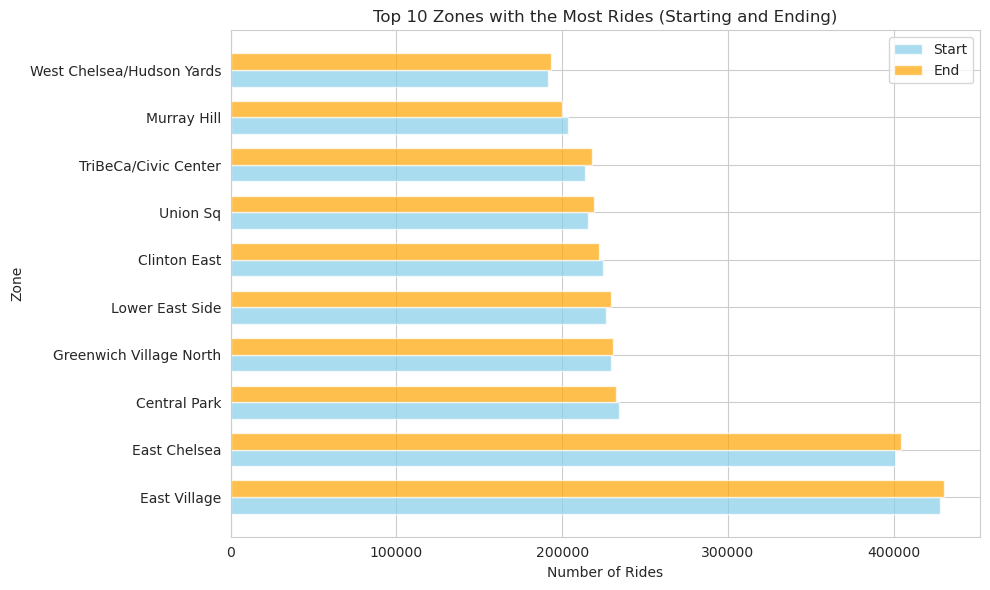

In [17]:
# Top 10 zones with the most rides
start_zone_counts = bike_dataset["start_zone"].value_counts().head(10)
end_zone_counts = bike_dataset["end_zone"].value_counts().head(10)

bar_height = 0.35

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(start_zone_counts))

# Plot starting zones
start_bars = ax.barh(index, start_zone_counts.values, bar_height, color='skyblue', label='Start', alpha=0.7)

# Plot ending zones
end_bars = ax.barh(index + bar_height, end_zone_counts.values, bar_height, color='orange', label='End', alpha=0.7)

ax.set_title("Top 10 Zones with the Most Rides (Starting and Ending)")
ax.set_ylabel("Zone")
ax.set_xlabel("Number of Rides")
ax.set_yticks(index + bar_height / 2)
ax.set_yticklabels(start_zone_counts.index) 

plt.legend()
plt.tight_layout()

# Save plot
plt.savefig('./plots/top_10_zones_most_rides.png')

plt.show()

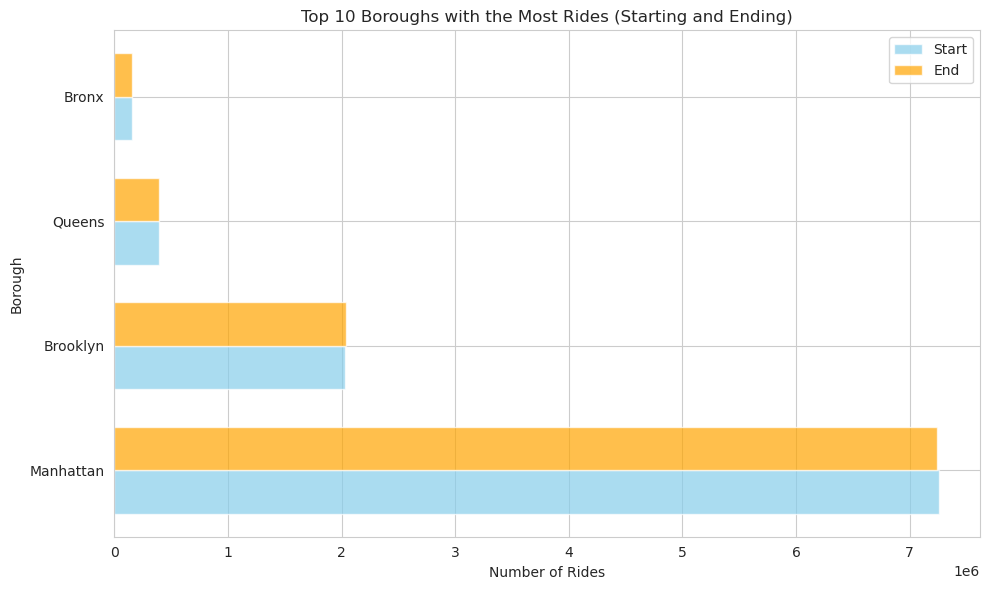

In [18]:
# Top 10 boroughs with the most rides
start_borough_counts = bike_dataset["start_borough"].value_counts().head(10)
end_borough_counts = bike_dataset["end_borough"].value_counts().head(10)

bar_height = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(start_borough_counts))

# Plot starting zones
start_bars = ax.barh(index, start_borough_counts.values, bar_height, color='skyblue', label='Start', alpha=0.7)

# Plot ending zones
end_bars = ax.barh(index + bar_height, end_borough_counts.values, bar_height, color='orange', label='End', alpha=0.7)

ax.set_title("Top 10 Boroughs with the Most Rides (Starting and Ending)")
ax.set_ylabel("Borough")
ax.set_xlabel("Number of Rides")
ax.set_yticks(index + bar_height / 2)
ax.set_yticklabels(start_borough_counts.index)

plt.legend()
plt.tight_layout()

# Save plot
plt.savefig('./plots/top_10_boroughs_most_rides.png')

plt.show()

#### Average distance per ride before and after covid

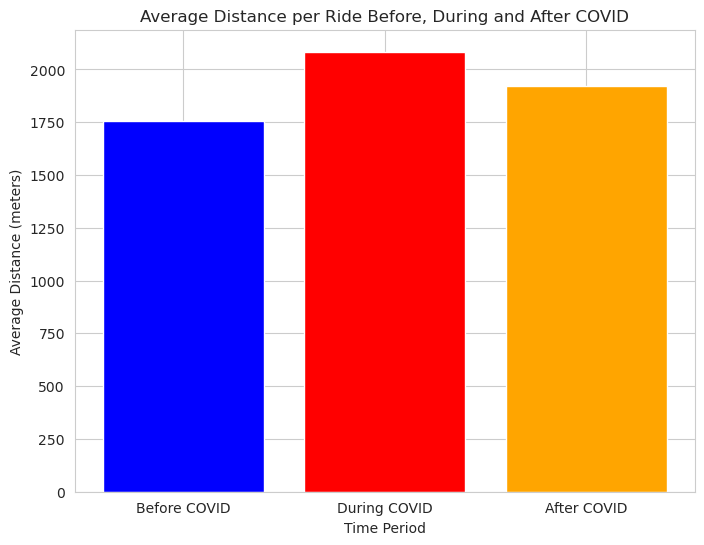

In [20]:
# Average distance per ride before and after covid
avg_distance_before_covid = before_covid["distance"].mean()
avg_distance_during_covid = during_covid["distance"].mean()
avg_distance_after_covid = after_covid["distance"].mean()

# Plot
labels = ['Before COVID', 'During COVID', 'After COVID']
avg_distances = [avg_distance_before_covid, avg_distance_during_covid, avg_distance_after_covid]

plt.figure(figsize=(8, 6))
plt.bar(labels, avg_distances, color=['blue', 'red', 'orange'])
plt.title('Average Distance per Ride Before, During and After COVID')
plt.ylabel('Average Distance (meters)')
plt.xlabel('Time Period')

# Save plot
plt.savefig('./plots/avg_distance_before_during_after_covid.png')

plt.show()

Let's dive deeper into time series of the distance per ride.

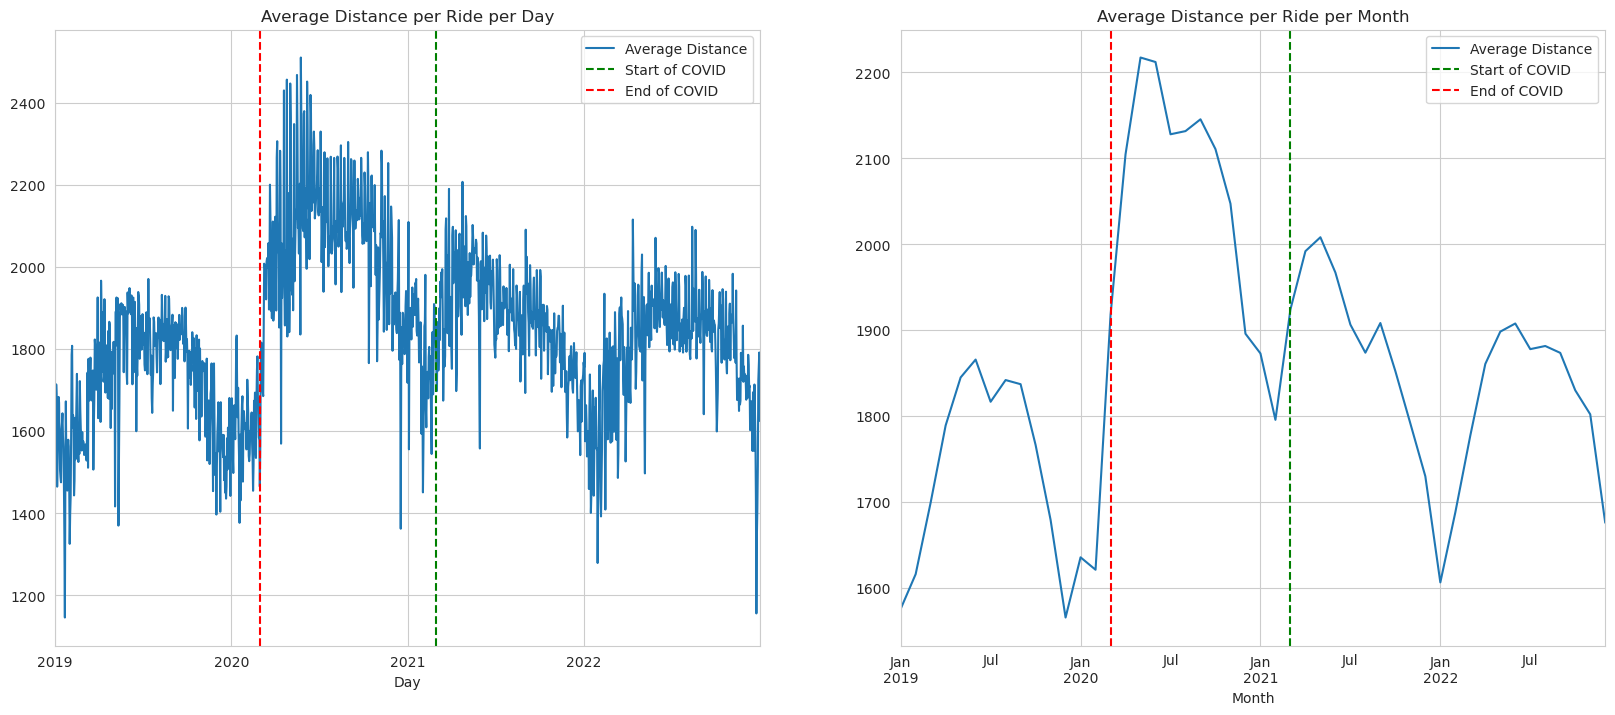

In [22]:
# Average distance per ride per day and month
daily_avg_distance = bike_dataset.groupby(bike_dataset["starttime"].dt.to_period('D'))["distance"].mean()
monthly_avg_distance = bike_dataset.groupby(bike_dataset["starttime"].dt.to_period('M'))["distance"].mean()

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

daily_avg_distance.plot(ax=ax[0])
ax[0].set_title("Average Distance per Ride per Day")
ax[0].set_xlabel("Day")

monthly_avg_distance.plot(ax=ax[1])
ax[1].set_title("Average Distance per Ride per Month")
ax[1].set_xlabel("Month")

# Vertical line for COVID
ax[0].axvline(x=pd.Timestamp("2021-03-01"), color='g', linestyle='--')
ax[0].axvline(x=pd.Timestamp("2020-03-01"), color='r', linestyle='--')
ax[1].axvline(x=pd.Timestamp("2021-03-01"), color='g', linestyle='--')
ax[1].axvline(x=pd.Timestamp("2020-03-01"), color='r', linestyle='--')

ax[0].legend(["Average Distance", "Start of COVID", "End of COVID"])
ax[1].legend(["Average Distance", "Start of COVID", "End of COVID"])

# Save plot
plt.savefig('./plots/avg_distance_per_day_month.png')

plt.show()

For the 3 most popular zones, did the average distance per ride change before and after COVID?

In [20]:
# For the top 10 zones, calculate the average distance per ride per zone
top_3_zones = bike_dataset["start_zone"].value_counts().head(3).index

zone_avg_distance_before_covid = before_covid[before_covid["start_zone"].isin(top_3_zones)].groupby("start_zone")["distance"].mean()
zone_avg_distance_during_covid = during_covid[during_covid["start_zone"].isin(top_3_zones)].groupby("start_zone")["distance"].mean()
zone_avg_distance_after_covid = after_covid[after_covid["start_zone"].isin(top_3_zones)].groupby("start_zone")["distance"].mean()

In [26]:
m = folium.Map(location=[40.7550, -73.9950], zoom_start=13)  # New York City coordinates

marker_cluster = MarkerCluster().add_to(m)

# Add markers for each centroid
for idx, row in zones.iterrows():
    if row['zone'] in top_3_zones:
        popup = folium.Popup(row['zone'], parse_html=True)
        folium.Marker([row['centroid'].y, row['centroid'].x], popup=popup).add_to(marker_cluster)
        
# Plot a circle starting from each centroid with a radius of the average distance
for zone, avg_distance in zone_avg_distance_before_covid.items():
    zone_centroid = zones[zones['zone'] == zone]['centroid'].values[0]
    folium.Circle([zone_centroid.y, zone_centroid.x], radius=avg_distance, color='blue').add_to(m)
    
for zone, avg_distance in zone_avg_distance_during_covid.items():
    zone_centroid = zones[zones['zone'] == zone]['centroid'].values[0]
    folium.Circle([zone_centroid.y, zone_centroid.x], radius=avg_distance, color='red').add_to(m)

for zone, avg_distance in zone_avg_distance_after_covid.items():
    zone_centroid = zones[zones['zone'] == zone]['centroid'].values[0]
    folium.Circle([zone_centroid.y, zone_centroid.x], radius=avg_distance, color='orange', fill=False).add_to(m)

m.save("./maps/top_3_zones_avg_distance.html")

In [27]:
bike_dataset.shape

(9830497, 12)

In [28]:
bike_dataset.head()

,starttime,stoptime,start_lat,start_lng,end_lat,end_lng,geometry,start_zone,end_zone,start_borough,end_borough,distance
0,2019-03-01 00:02:01.694,2019-03-01 00:55:20.636,40.714852,-74.011223,40.715338,-74.016584,POINT (-74.01122 40.71485),TriBeCa/Civic Center,Battery Park City,Manhattan,Manhattan,456.129096
1,2019-03-01 00:03:18.743,2019-03-01 00:10:23.900,40.733143,-73.975739,40.724537,-73.981854,POINT (-73.97574 40.73314),Stuy Town/Peter Cooper Village,East Village,Manhattan,Manhattan,1086.313247
2,2019-03-01 00:04:32.594,2019-03-01 00:30:34.850,40.780184,-73.977285,40.739126,-73.979738,POINT (-73.97729 40.78018),Upper West Side South,Kips Bay,Manhattan,Manhattan,4564.156848
3,2019-03-01 00:06:12.211,2019-03-01 00:45:02.248,40.759291,-73.988597,40.710451,-73.960876,POINT (-73.98860 40.75929),Clinton East,Williamsburg (South Side),Manhattan,Brooklyn,5907.539187
4,2019-03-01 00:08:51.048,2019-03-01 00:17:51.090,40.729039,-73.994046,40.720874,-73.980858,POINT (-73.99405 40.72904),Greenwich Village North,Alphabet City,Manhattan,Manhattan,1436.567916
